In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from stardist.models import StarDist2D
from stardist.plot import render_label
from src.utils.helpers import cut_out_image
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops
from typing import List, Dict, Tuple
from numpy.typing import NDArray
from collections import defaultdict
from tqdm import tqdm
from src.utils.helpers import compare_two_images, clean_mask

bioimageio_utils.py (2): pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


In [3]:
model = StarDist2D.from_pretrained("2D_versatile_he")

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [4]:
image_paths = sorted(
    [
        str(project_root)+"/data/normalized_images/" + path
        for path in os.listdir(str(project_root)+"/data/normalized_images")
        if not path.startswith(".")
    ]
)
mask_paths = sorted(
    [
        str(project_root)+"/data/masks/" + path
        for path in os.listdir(str(project_root)+"/data/masks")
        if not path.startswith(".")
    ]
)
images = list(map(tifffile.imread, image_paths))
masks = list(map(tifffile.imread, mask_paths))
data = list(zip(images, masks))

In [17]:
# for image, mask in data:
#     cleaned_mask = clean_mask(mask)
#     image_normed = rescale_intensity(image, out_range=(0, 1))

#     labels, data_dict = model.predict_instances(image_normed, axes='YXC', prob_thresh=0.05, nms_thresh=0.3, return_labels=True)

#     plt.figure(figsize=(24, 12))

#     filtered_labels = cut_out_image(labels, cleaned_mask)
#     binary_labels = (filtered_labels > 0).astype(np.uint8)

#     plt.subplot(1,2,1)
#     plt.imshow(image)
#     plt.axis("off")
#     plt.title("input image")

#     plt.subplot(1,2,2)
#     plt.imshow(render_label(filtered_labels, img=image_normed, cmap=(1.0, 1.0, 0), alpha=0.6))
#     plt.axis("off")
#     plt.title("prediction + input overlay")

#     plt.show()

In [ ]:
def extract_stardist_features(
    labels: NDArray[np.floating], data_dict: Dict[str, NDArray[np.floating]]
) -> pd.DataFrame:

    props = regionprops(labels)

    coordinates = data_dict.get("coord", [])
    points = data_dict.get("points", [])
    probabilities = data_dict.get("prob", [])

    features = []

    for i, prop in enumerate(props):
        feature_dict = {
            "label_id": prop.label,
            "area": prop.area,
            "perimeter": prop.perimeter,
            "centroid_y": prop.centroid[0],
            "centroid_x": prop.centroid[1],
            "bbox_min_row": prop.bbox[0],
            "bbox_min_col": prop.bbox[1],
            "bbox_max_row": prop.bbox[2],
            "bbox_max_col": prop.bbox[3],
            "eccentricity": prop.eccentricity,
            "solidity": prop.solidity,
            "extent": prop.extent,
            "major_axis_length": prop.major_axis_length,
            "minor_axis_length": prop.minor_axis_length,
            "orientation": prop.orientation,
            "equivalent_diameter": prop.equivalent_diameter,
        }

        if i < len(probabilities):
            feature_dict["stardist_probability"] = probabilities[i]

        if i < len(coordinates):
            feature_dict["stardist_distances_y"] = (
                coordinates[i][0] if len(coordinates[i]) > 0 else None
            )
            feature_dict["stardist_distances_x"] = (
                coordinates[i][1] if len(coordinates[i]) > 1 else None
            )

        features.append(feature_dict)

    return pd.DataFrame(features)

In [ ]:
def get_segmentation_summary(
    labels: NDArray[np.floating], data_dict: Dict[str, NDArray[np.floating]]
) -> dict:
    probabilities = data_dict.get("prob", [])
    total_objects = len(probabilities)

    if total_objects == 0 or len(np.unique(labels.flatten())) == 1:
        return {
            "total_objects": 0,
            "average_area": 0,
            "median_area": 0,
            "std_area": 0,
            "average_probability": 0,
            "median_probability": 0,
        }

    areas = np.bincount(labels.flatten())[1:]
    areas = areas[areas > 0]

    probabilities = np.array(probabilities)

    summary = {
        "total_objects": total_objects,
        "average_area": float(np.mean(areas)),
        "median_area": float(np.median(areas)),
        "std_area": float(np.std(areas)),
        "average_probability": float(np.mean(probabilities)),
        "median_probability": float(np.median(probabilities)),
    }

    return summary

In [ ]:
def visualize_segmentation(x: List[float], y: Dict[str, List[float]]) -> None:
    num_plots = len(y)
    rows = (num_plots + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(20, 6 * rows))
    axes = axes.flatten()

    for idx, (label, values) in enumerate(y.items()):
        ax = axes[idx]
        ax.plot(x, values, marker="o", linewidth=2, color="blue")

        ax.set_xlabel("Parameter Values")
        ax.set_ylabel(label)
        ax.set_title(f"{label} vs Parameters")

        ax.grid(True, alpha=0.3)

    for idx in range(len(y), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

### Tuning of prob and nms threshold

In [76]:
def run_segmentation_analysis(data, prob_thresholds):
    segmentation_summary = defaultdict(list)
    for i, th in enumerate(prob_thresholds):
        print(f"Processing threshold {i + 1}/{len(prob_thresholds)}")
        number_of_objects = []
        average_areas = []
        average_probs = []
        for image, mask in tqdm(data):
            image_normed = rescale_intensity(image, out_range=(0, 1))
            labels, data_dict = model.predict_instances(
                image_normed,
                axes="YXC",
                prob_thresh=th,
                nms_thresh=0.3,
                return_labels=True,
            )
            labels = cut_out_image(labels, mask)
            summary = get_segmentation_summary(labels=labels, data_dict=data_dict)

            number_of_objects.append(summary["total_objects"])
            average_areas.append(summary["average_area"])
            average_probs.append(summary["average_probability"])

        segmentation_summary["total_objects"].append(np.mean(number_of_objects))
        segmentation_summary["average_area"].append(np.mean(average_areas))
        segmentation_summary["average_probability"].append(np.mean(average_probs))

    return segmentation_summary

In [ ]:
def run_segmentation_analysis_nms(data, prob_threshold, nms_thresholds):
    segmentation_summary = defaultdict(list)
    for i, th in enumerate(nms_thresholds):
        print(f"Processing threshold {i + 1}/{len(nsm_thresholds)}")
        number_of_objects = []
        average_areas = []
        average_probs = []
        for image, mask in tqdm(data):
            image_normed = rescale_intensity(image, out_range=(0, 1))
            labels, data_dict = model.predict_instances(
                image_normed,
                axes="YXC",
                prob_thresh=prob_threshold,
                nms_thresh=th,
                return_labels=True,
            )
            labels = cut_out_image(labels, mask)
            summary = get_segmentation_summary(labels=labels, data_dict=data_dict)

            number_of_objects.append(summary["total_objects"])
            average_areas.append(summary["average_area"])
            average_probs.append(summary["average_probability"])

        segmentation_summary["total_objects"].append(np.mean(number_of_objects))
        segmentation_summary["average_area"].append(np.mean(average_areas))
        segmentation_summary["average_probability"].append(np.mean(average_probs))

    return segmentation_summary

In [77]:
prob_thresholds_rough = np.arange(0.1, 1.1, 0.1)
prob_thresholds_rough

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [78]:
segmentation_summary_roughly = run_segmentation_analysis(
    data=data, prob_thresholds=prob_thresholds_rough
)

Processing threshold 1/10


100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


Processing threshold 2/10


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Processing threshold 3/10


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


Processing threshold 4/10


100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


Processing threshold 5/10


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Processing threshold 6/10


100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


Processing threshold 7/10


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


Processing threshold 8/10


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Processing threshold 9/10


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Processing threshold 10/10


100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


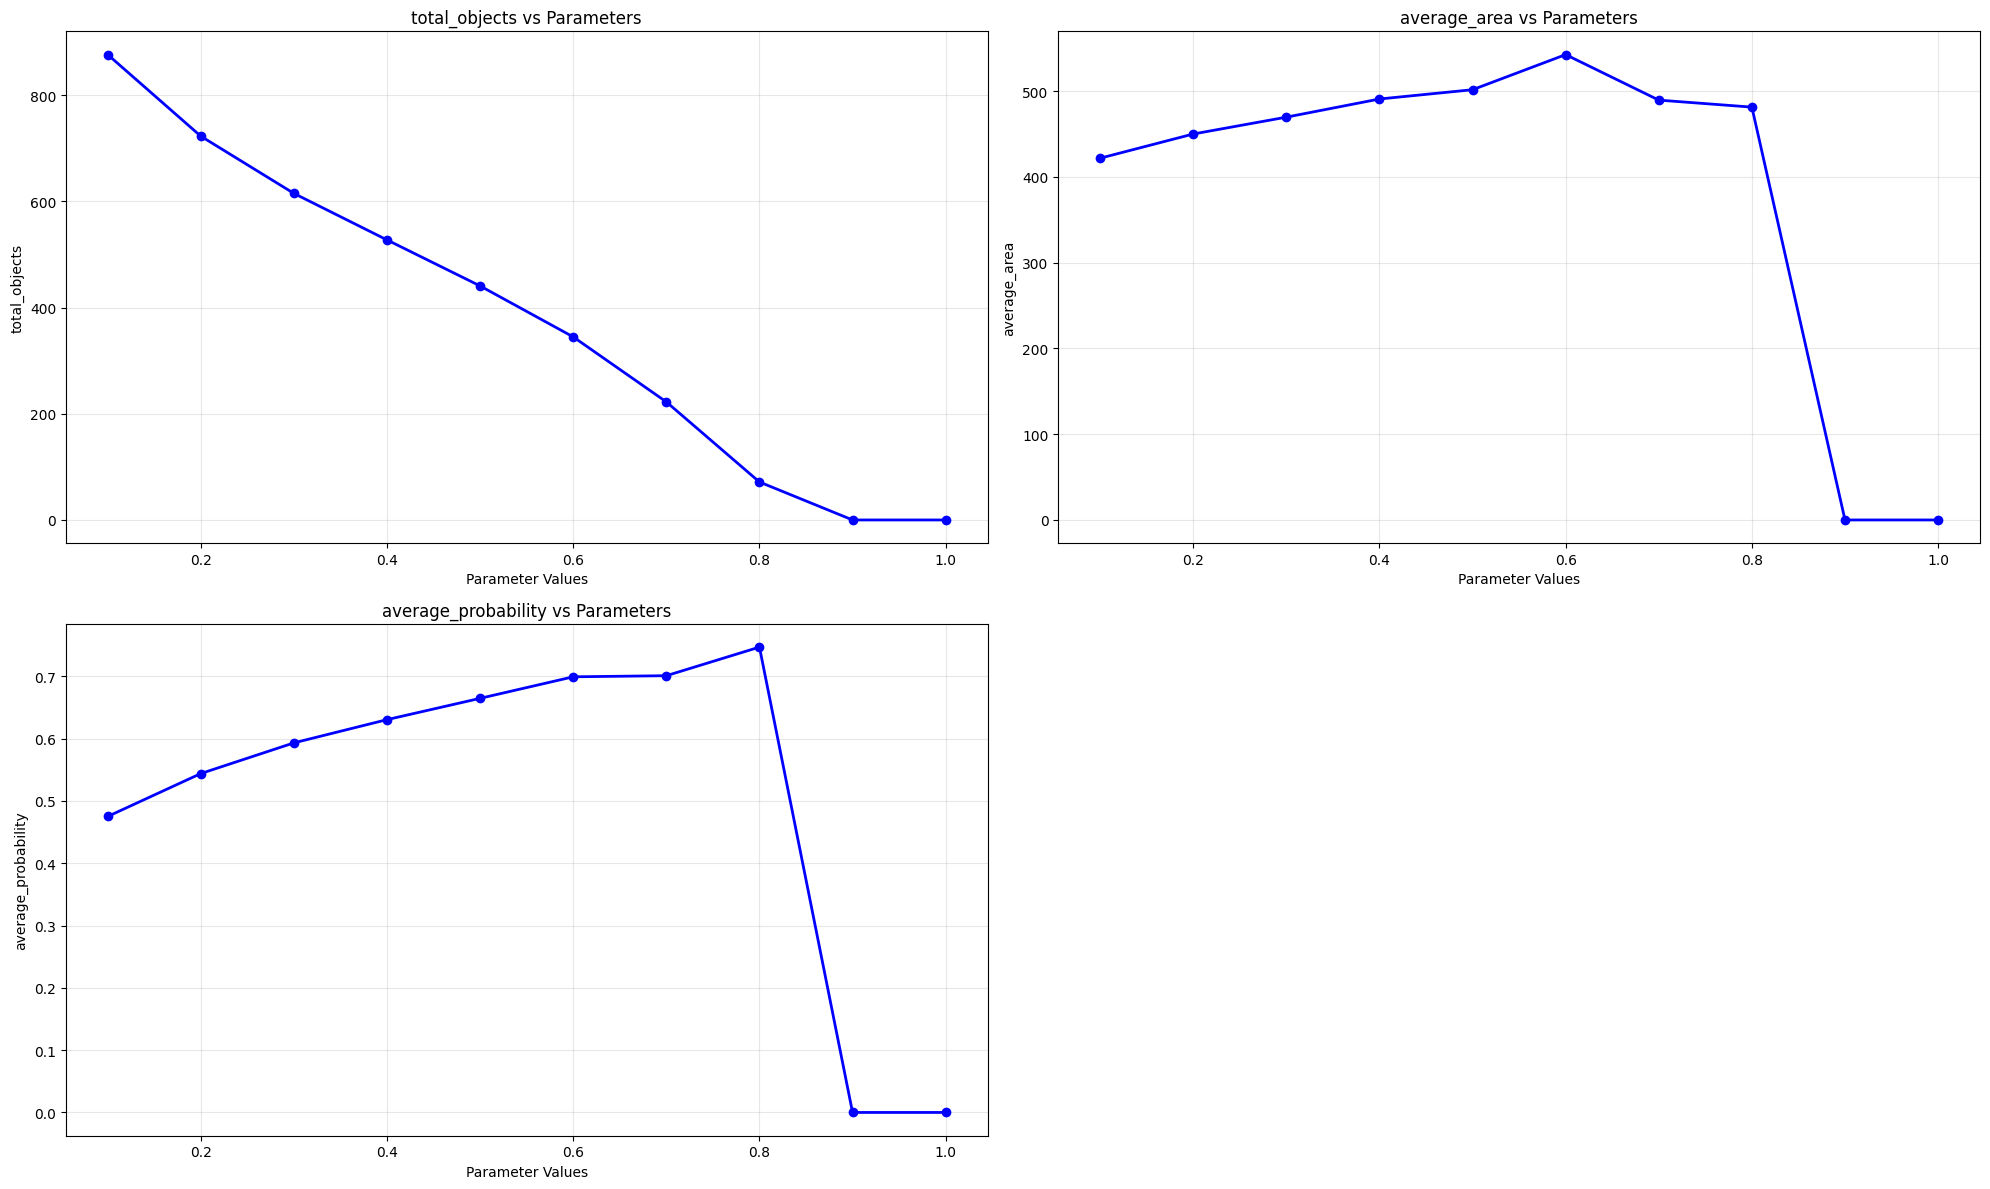

In [81]:
segmentation_summary_roughly = dict(segmentation_summary_roughly)
visualize_segmentation(prob_thresholds_rough, segmentation_summary_roughly)

In [84]:
prob_thresholds = np.arange(0.0, 0.45, 0.05)
prob_thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ])

In [85]:
segmentation_summary_fine_grained = run_segmentation_analysis(
    data=data, prob_thresholds=prob_thresholds
)

Processing threshold 1/9


100%|██████████| 20/20 [08:05<00:00, 24.29s/it]


Processing threshold 2/9


100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


Processing threshold 3/9


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


Processing threshold 4/9


100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Processing threshold 5/9


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Processing threshold 6/9


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


Processing threshold 7/9


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Processing threshold 8/9


100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Processing threshold 9/9


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


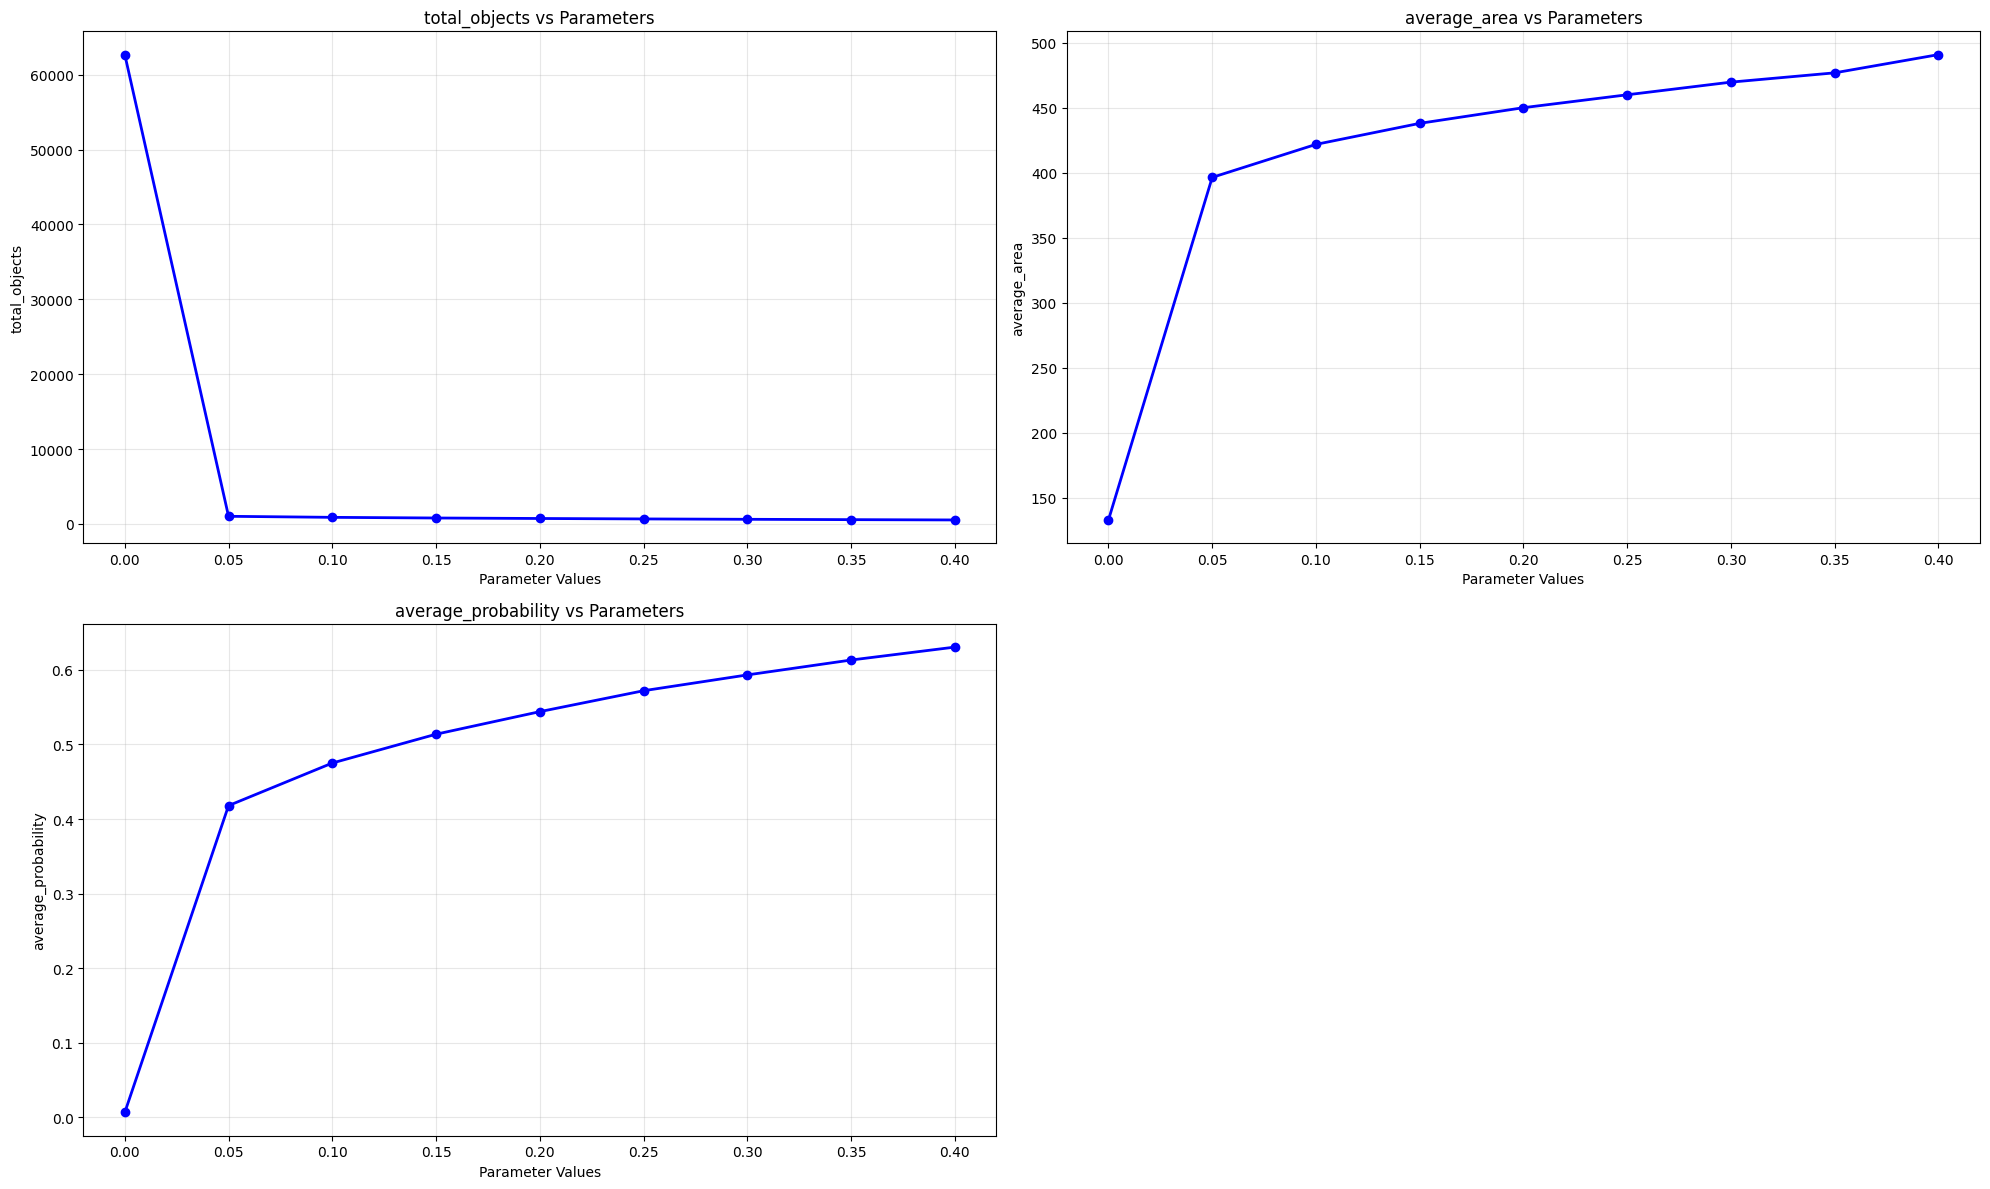

In [87]:
segmentation_summary_fine_grained = dict(segmentation_summary_fine_grained)
visualize_segmentation(prob_thresholds, segmentation_summary_fine_grained)

In [5]:
# example_image = data[0][0]
# plt.imshow(example_image)

In [90]:
example_mask = data[0][1]
example_image_normed = rescale_intensity(example_image, out_range=(0, 1))
labels_1, data_dict_1 = model.predict_instances(
    example_image_normed,
    axes="YXC",
    prob_thresh=0.1,
    nms_thresh=0.3,
    return_labels=True,
)
labels_2, data_dict_2 = model.predict_instances(
    example_image_normed,
    axes="YXC",
    prob_thresh=0.2,
    nms_thresh=0.3,
    return_labels=True,
)
labels_1 = cut_out_image(labels_1, example_mask)
labels_2 = cut_out_image(labels_2, example_mask)

In [6]:
# compare_two_images(
#     render_label(labels_1, img=example_image_normed, cmap=(1.0, 1.0, 0), alpha=0.6),
#     render_label(labels_2, img=example_image_normed, cmap=(1.0, 1.0, 0), alpha=0.6),
# )

In [7]:
# example_mask = data[0][1]
# example_image_normed = rescale_intensity(example_image, out_range=(0, 1))
# labels_1, data_dict_1 = model.predict_instances(
#     example_image_normed,
#     axes="YXC",
#     prob_thresh=0.05,
#     nms_thresh=0.3,
#     return_labels=True,
# )
# labels_2, data_dict_2 = model.predict_instances(
#     example_image_normed,
#     axes="YXC",
#     prob_thresh=0.1,
#     nms_thresh=0.3,
#     return_labels=True,
# )
# labels_1 = cut_out_image(labels_1, example_mask)
# labels_2 = cut_out_image(labels_2, example_mask)
# compare_two_images(
#     render_label(labels_1, img=example_image_normed, cmap=(1.0, 1.0, 0), alpha=0.6),
#     render_label(labels_2, img=example_image_normed, cmap=(1.0, 1.0, 0), alpha=0.6),
# )

In [92]:
prob_thresholds_nms_rough = np.arange(0.1, 1.1, 0.1)
prob_thresholds_nms_rough

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [93]:
segmentation_summary_nms_roughly = run_segmentation_analysis_nms(
    data=data, prob_threshold=0.1, nms_thresholds=prob_thresholds_nms_rough
)

Processing threshold 1/9


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Processing threshold 2/9


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Processing threshold 3/9


100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


Processing threshold 4/9


100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


Processing threshold 5/9


100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


Processing threshold 6/9


100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


Processing threshold 7/9


100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


Processing threshold 8/9


100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


Processing threshold 9/9


100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


Processing threshold 10/9


100%|██████████| 20/20 [05:31<00:00, 16.56s/it]


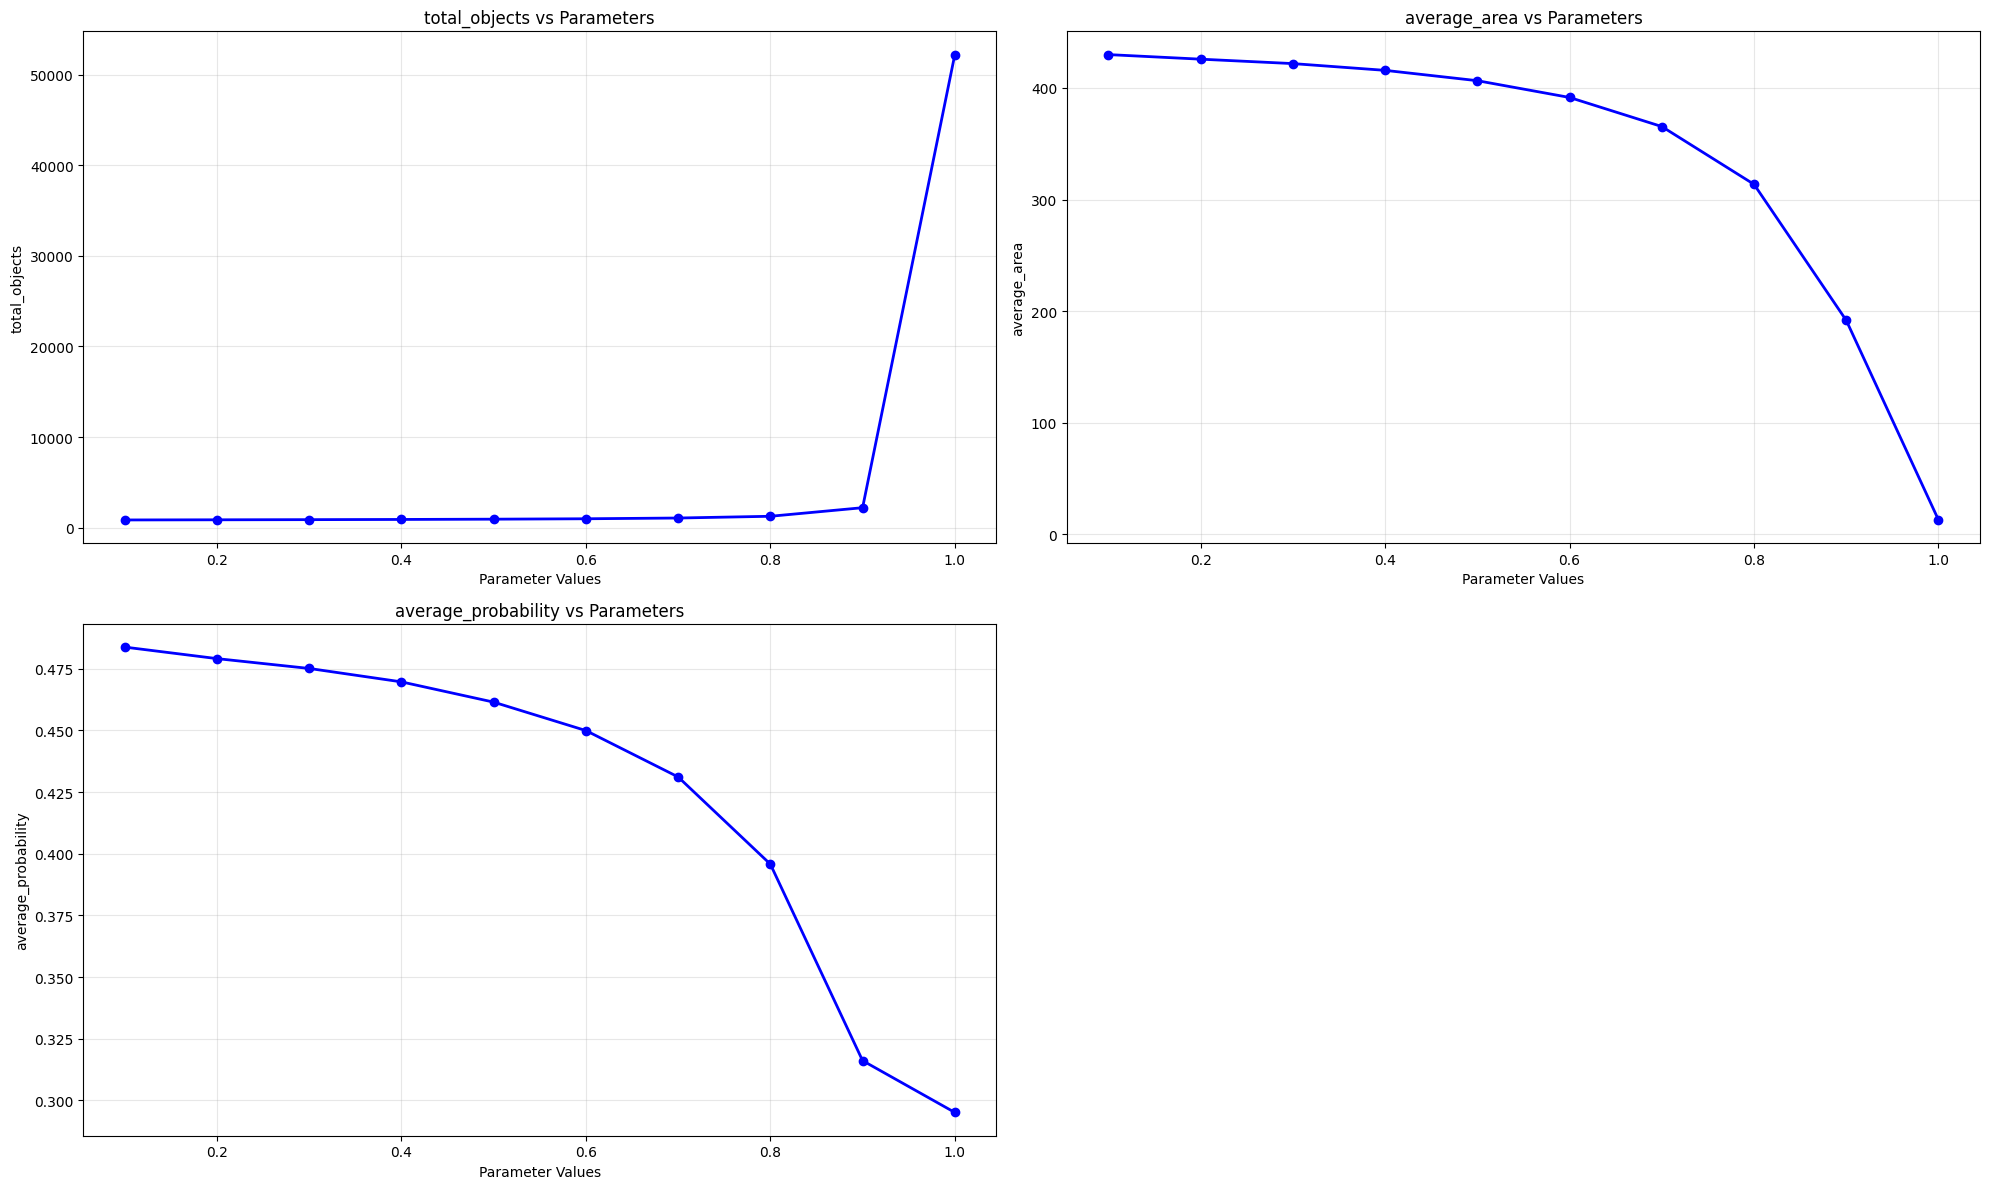

In [94]:
segmentation_summary_nms_roughly = dict(segmentation_summary_nms_roughly)
visualize_segmentation(prob_thresholds_nms_rough, segmentation_summary_nms_roughly)

### Results
It seems that the qualitatively found parameters prob_th = 0.05 and nms_th = 0.3 are reasonable values to obtain good results

In [ ]:
# Example plots for presentation

# for image, mask in data:
#     image_normed = rescale_intensity(image, out_range=(0, 1))
#     labels, data_dict = model.predict_instances(image_normed, axes='YXC', prob_thresh=0.05, nms_thresh=0.3, return_labels=True)
#     labels = cut_out_image(labels, mask)
#     compare_two_images(image, render_label(labels, img=image, cmap=(1.0, 1.0, 0), alpha=0.6), "Original Image", "Segmentation Overlay")

### Compare Normalized vs. Non-Normalized

In [10]:
nn_image_paths = sorted(
    [
        "data/images/" + path
        for path in os.listdir("data/images")
        if not path.startswith(".")
    ]
)
mask_paths = sorted(
    [
        "data/masks/" + path
        for path in os.listdir("data/masks")
        if not path.startswith(".")
    ]
)
nn_images = list(map(tifffile.imread, nn_image_paths))
masks = list(map(tifffile.imread, mask_paths))
nn_data = list(zip(nn_images, masks))

In [8]:
# compare_two_images(data[3][0], nn_data[3][0])

In [99]:
PROB_TH = 0.05
NMS_TH = 0.3

In [ ]:
def calculate_segmentation_stats(
    data: List[Tuple[np.array, np.array]], prob_th, nms_th
) -> Dict[str, float]:
    segmentation_summary = defaultdict(list)
    number_of_objects = []
    average_areas = []
    average_probs = []
    for image, mask in tqdm(data):
        image_normed = rescale_intensity(image, out_range=(0, 1))
        labels, data_dict = model.predict_instances(
            image_normed,
            axes="YXC",
            prob_thresh=prob_th,
            nms_thresh=nms_th,
            return_labels=True,
        )
        labels = cut_out_image(labels, mask)
        summary = get_segmentation_summary(labels=labels, data_dict=data_dict)

        number_of_objects.append(summary["total_objects"])
        average_areas.append(summary["average_area"])
        average_probs.append(summary["average_probability"])

    segmentation_summary["total_objects"] = np.mean(number_of_objects)
    segmentation_summary["average_area"] = np.mean(average_areas)
    segmentation_summary["average_probability"] = np.mean(average_probs)

    return segmentation_summary

In [ ]:
segmentation_summary_normalized = calculate_segmentation_stats(data, PROB_TH, NMS_TH)
segmentation_summary_normalized

100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


defaultdict(list,
            {'total_objects': 1015.15,
             'average_area': 396.40265291552817,
             'average_probability': 0.41804262697696687})

In [ ]:
segmentation_summary_nn = calculate_segmentation_stats(nn_data, PROB_TH, NMS_TH)
segmentation_summary_nn

100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


defaultdict(list,
            {'total_objects': 1004.95,
             'average_area': 400.694976824483,
             'average_probability': 0.4072545312345028})

We can see that the average probability and average number of detected objects is higher in the normalized images, showing the effectiveness of normalization

### Grayscale Segmentation

In [14]:
gs_model = StarDist2D.from_pretrained("2D_versatile_fluo")

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [9]:
# from skimage.color import rgb2gray

# example_image_gray = rgb2gray(data[0][0])
# plt.imshow(example_image_gray, cmap="gray")

In [111]:
gray_data = [(rgb2gray(img), mask) for img, mask in data]

In [118]:
def calculate_segmentation_stats_gray(
    data: List[Tuple[np.array, np.array]], prob_th, nms_th
) -> Dict[str, float]:
    segmentation_summary = defaultdict(list)
    number_of_objects = []
    average_areas = []
    average_probs = []
    for image, mask in tqdm(data):
        image_normed = rescale_intensity(image, out_range=(0, 1))
        labels, data_dict = gs_model.predict_instances(
            image_normed,
            axes="YX",
            prob_thresh=prob_th,
            nms_thresh=nms_th,
            return_labels=True,
        )
        labels = cut_out_image(labels, mask)
        summary = get_segmentation_summary(labels=labels, data_dict=data_dict)

        number_of_objects.append(summary["total_objects"])
        average_areas.append(summary["average_area"])
        average_probs.append(summary["average_probability"])

    segmentation_summary["total_objects"] = np.mean(number_of_objects)
    segmentation_summary["average_area"] = np.mean(average_areas)
    segmentation_summary["average_probability"] = np.mean(average_probs)

    return segmentation_summary

In [119]:
segmentation_summary_gray = calculate_segmentation_stats_gray(
    gray_data, PROB_TH, NMS_TH
)
segmentation_summary_gray

100%|██████████| 20/20 [01:22<00:00,  4.13s/it]


defaultdict(list,
            {'total_objects': 1761.25,
             'average_area': 286.04795831617554,
             'average_probability': 0.2988446235656738})

In [10]:
# example_img_1, example_mask_1 = gray_data[0]
# example_img_2, example_mask_2 = gray_data[3]
# example_img_1_normed = rescale_intensity(example_img_1, out_range=(0, 1))
# example_img_2_normed = rescale_intensity(example_img_2, out_range=(0, 1))
# labels_1, data_dict_1 = gs_model.predict_instances(
#     example_img_1_normed,
#     axes="YX",
#     prob_thresh=0.05,
#     nms_thresh=0.3,
#     return_labels=True,
# )
# labels_2, data_dict_2 = gs_model.predict_instances(
#     example_img_2_normed,
#     axes="YX",
#     prob_thresh=0.05,
#     nms_thresh=0.3,
#     return_labels=True,
# )
# labels_1 = cut_out_image(labels_1, example_mask_1)
# labels_2 = cut_out_image(labels_2, example_mask_2)
# compare_two_images(
#     render_label(labels_1, img=example_img_1, cmap=(1.0, 1.0, 0), alpha=0.6),
#     render_label(labels_2, img=example_img_2, cmap=(1.0, 1.0, 0), alpha=0.6),
# )

We can see that the grayscale results are very bad, where a lot of small objects with low probability are segmented. That makes sense as the contrast is almost completely lost when just turning the image into grayscale. Color deconvolution could provide better results

In [12]:
import histomicstk as htk

In [124]:
process_img = data[0][0]

In [ ]:
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
stains = [
    "hematoxylin",  # nuclei stain
    "eosin",
    "null",
]

W = np.array([stain_color_map[st] for st in stains]).T
img_dec = htk.preprocessing.color_deconvolution.color_deconvolution(process_img, W)
print(img_dec.Stains.shape)

(1920, 2560, 3)


In [172]:
# for i in range(3):
#     plt.imshow(img_dec.Stains[:, :, i], cmap='gray')
#     plt.axis(False)
#     plt.title(f"Stain: {stains[i]}")
#     plt.show()

In [135]:
def enhance_contrast_clahe(image, clip_limit=0.01, kernel_size=None):
    """
    CLAHE (Contrast Limited Adaptive Histogram Equalization)
    Best for medical/microscopy images
    """
    from skimage.exposure import equalize_adapthist

    # Ensure image is in [0, 1] range
    if image.max() > 1:
        image = image.astype(np.float64) / 255.0

    # Apply CLAHE
    enhanced = equalize_adapthist(image, clip_limit=clip_limit, kernel_size=kernel_size)

    return enhanced

In [136]:
enhanced_dec_img = enhance_contrast_clahe(img_dec.Stains[:, :, 0])

In [11]:
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.axis(False)
# plt.title("Before CLAHE")
# plt.imshow(img_dec.Stains[:, :, 0], cmap="gray")

# plt.subplot(1, 2, 2)
# plt.axis(False)
# plt.title("After CLAHE")
# plt.imshow(enhanced_dec_img, cmap="gray")

# plt.show()

In [8]:
def color_deconvolution_gray_conversion(
    image: np.array, clip_limit: float = 0.01
) -> np.array:
    from skimage.exposure import equalize_adapthist

    stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
    stains = [
        "hematoxylin",  # nuclei stain
        "eosin",
        "null",
    ]

    W = np.array([stain_color_map[st] for st in stains]).T
    img_dec = htk.preprocessing.color_deconvolution.color_deconvolution(image, W)
    img_dec = img_dec.Stains[:, :, 0]
    enhanced = equalize_adapthist(img_dec, clip_limit=clip_limit)
    return enhanced

In [13]:
dec_data = [(color_deconvolution_gray_conversion(img), mask) for img, mask in nn_data]

In [165]:
# for normal_image, dec_image in zip([item[0] for item in data], [item[0] for item in dec_data]):
#     plt.figure(figsize=(12, 6))

#     plt.subplot(1, 2, 1)
#     plt.axis(False)
#     plt.title("RGB normalized image")
#     plt.imshow(normal_image)

#     plt.subplot(1, 2, 2)
#     plt.axis(False)
#     plt.title("Deconvolved image")
#     plt.imshow(dec_image, cmap='gray')

#     plt.show()

In [167]:
segmentation_summary_dec = calculate_segmentation_stats_gray(dec_data, 0.479071, 0.3)
segmentation_summary_dec

100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


defaultdict(list,
            {'total_objects': 756.4,
             'average_area': 293.9395533324877,
             'average_probability': 0.6198627352714539})

In [168]:
def run_segmentation_analysis_gray(data, prob_thresholds):
    segmentation_summary = defaultdict(list)
    for i, th in enumerate(prob_thresholds):
        print(f"Processing threshold {i + 1}/{len(prob_thresholds)}")
        number_of_objects = []
        average_areas = []
        average_probs = []
        for image, mask in tqdm(data):
            image_normed = rescale_intensity(image, out_range=(0, 1))
            labels, data_dict = gs_model.predict_instances(
                image_normed,
                axes="YX",
                prob_thresh=th,
                nms_thresh=0.3,
                return_labels=True,
            )
            labels = cut_out_image(labels, mask)
            summary = get_segmentation_summary(labels=labels, data_dict=data_dict)

            number_of_objects.append(summary["total_objects"])
            average_areas.append(summary["average_area"])
            average_probs.append(summary["average_probability"])

        segmentation_summary["total_objects"].append(np.mean(number_of_objects))
        segmentation_summary["average_area"].append(np.mean(average_areas))
        segmentation_summary["average_probability"].append(np.mean(average_probs))

    return segmentation_summary

In [169]:
prob_thresholds_rough = np.arange(0.1, 1.1, 0.1)
prob_thresholds_rough

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [170]:
segmentation_summary_dec_roughly = run_segmentation_analysis_gray(
    data=dec_data, prob_thresholds=prob_thresholds_rough
)

Processing threshold 1/10


100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


Processing threshold 2/10


100%|██████████| 20/20 [01:30<00:00,  4.53s/it]


Processing threshold 3/10


100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Processing threshold 4/10


100%|██████████| 20/20 [00:38<00:00,  1.92s/it]


Processing threshold 5/10


100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


Processing threshold 6/10


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Processing threshold 7/10


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Processing threshold 8/10


100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


Processing threshold 9/10


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Processing threshold 10/10


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


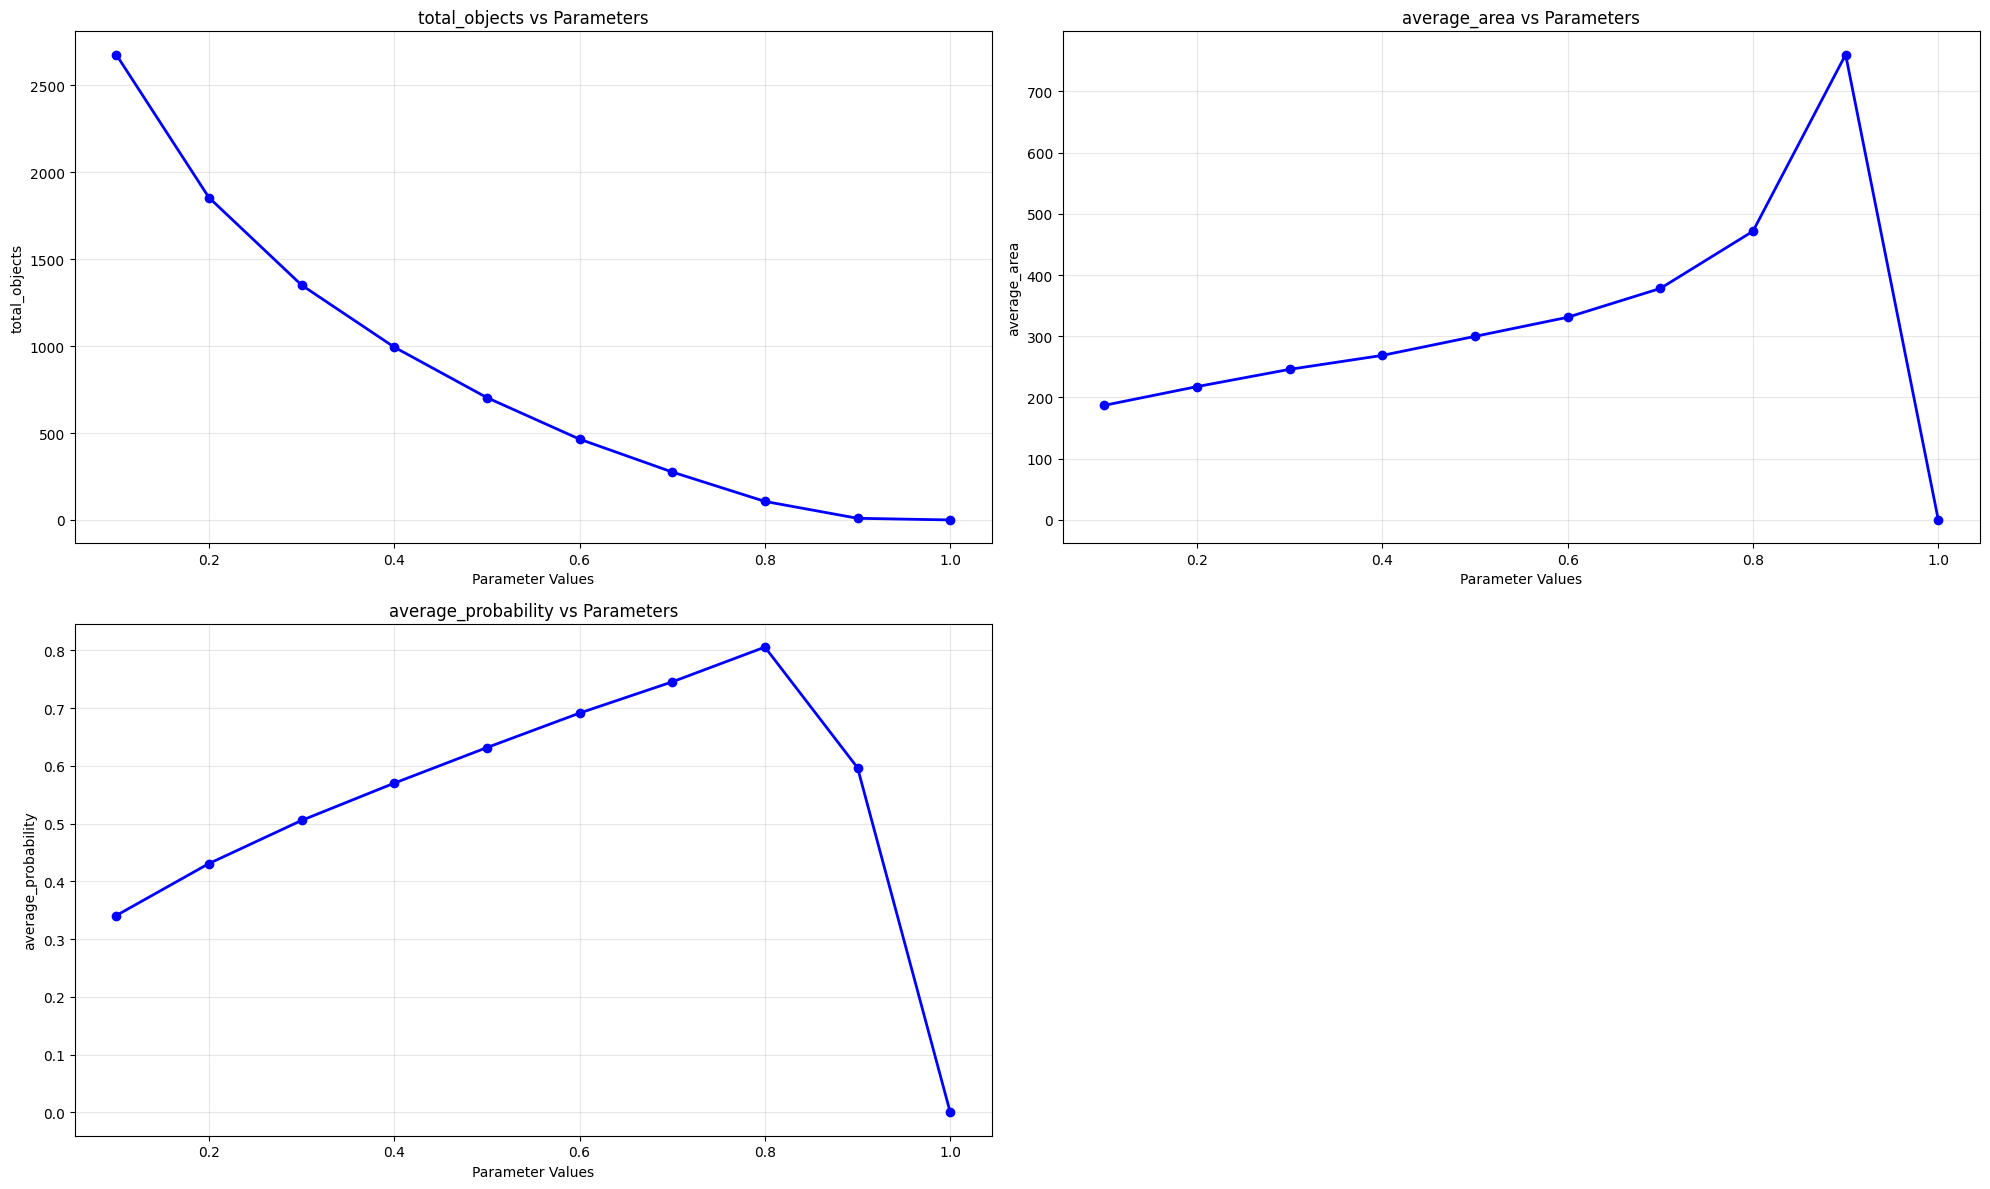

In [171]:
segmentation_summary_dec_roughly = dict(segmentation_summary_dec_roughly)
visualize_segmentation(prob_thresholds_rough, segmentation_summary_dec_roughly)

In [22]:
# for i, (img, mask) in enumerate(dec_data):
#     image_normed = rescale_intensity(img, out_range=(0, 1))
#     c_img = data[i][0]
#     c_image_normed = rescale_intensity(c_img, out_range=(0, 1))
#     labels, data_dict = gs_model.predict_instances(image_normed, axes='YX', prob_thresh=0.05, nms_thresh=0.3, return_labels=True)
#     c_labels, _ = model.predict_instances(c_image_normed, axes='YXC', prob_thresh=0.05, nms_thresh=0.3, return_labels=True)
#     labels = cut_out_image(labels, mask)
#     c_labels = cut_out_image(c_labels, mask)
#     plt.figure(figsize=(18, 6))

#     plt.subplot(1, 3, 1)
#     plt.axis(False)
#     plt.title("Simulated Fluorescence Image")
#     plt.imshow(img, cmap='gray')

#     plt.subplot(1, 3, 2)
#     plt.axis(False)
#     plt.title("Fluorescence Segmentation Map")
#     plt.imshow(labels)

#     plt.subplot(1, 3, 3)
#     plt.axis(False)
#     plt.title("Color Segmentation Map")
#     plt.imshow(c_labels)

#     plt.show()

### Results
Even though the color deconvolved images looked promising, the qualitative results are very bad, probably the color distribution of the deconvolved image does not match the color distribution of an original fluorescence model.